In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeLLM
from sklearn.preprocessing import MinMaxScaler
from neuralforecast.losses.pytorch import RMSE
from neuralforecast.utils import augment_calendar_df
from transformers import GPT2Config, GPT2Model, GPT2Tokenizer, BertConfig, BertModel, BertTokenizer
torch.set_float32_matmul_precision('medium')

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from datasetsforecast.long_horizon import LongHorizon
# Y_df, X_df, _ = LongHorizon.load(directory='./', group='ETTh1')
# Y_df['ds'] = pd.to_datetime(Y_df['ds'])
# X_df['ds'] = pd.to_datetime(X_df['ds'])
# Y_df = Y_df.merge(X_df, on=['unique_id', 'ds'], how='left')

In [20]:
df = pd.read_csv("dataset/ETT-small/ETTh1.csv")
df = df.rename(columns={"date": "ds"})
df["ds"] = pd.to_datetime(df["ds"])
df["unique_id"] = "OT" # required for fit function
df, calendar_cols = augment_calendar_df(df=df, freq='H')

In [21]:
df = df[df["ds"]>"2018-03-01"]

In [22]:
df = df[["unique_id", "ds", "dayhour", "OT"]]

In [7]:
hufl_scaler = MinMaxScaler()
hull_scaler = MinMaxScaler()
mufl_scaler = MinMaxScaler()
mull_scaler = MinMaxScaler()
lufl_scaler = MinMaxScaler()
lull_scaler = MinMaxScaler()
ot_scaler = MinMaxScaler()

In [23]:
# df['HUFL'] = hufl_scaler.fit_transform(df[['HUFL']])
# df['HULL'] = hull_scaler.fit_transform(df[['HULL']])
# df['MUFL'] = mufl_scaler.fit_transform(df[['MUFL']])
# df['MULL'] = mull_scaler.fit_transform(df[['MULL']])
# df['LUFL'] = lufl_scaler.fit_transform(df[['LUFL']])
# df['LULL'] = lull_scaler.fit_transform(df[['LULL']])
df['OT'] = ot_scaler.fit_transform(df[['OT']])


In [10]:
horizon = int(24*7) # predicting 7 days ahead
horizon

168

In [24]:
Y_train_df = df[df.ds<df['ds'].values[-horizon]]
Y_test_df = df[df.ds>=df['ds'].values[-horizon]].reset_index(drop=True)

In [25]:
Y_train_df

,unique_id,ds,dayhour,OT
14593,OT,2018-03-01 01:00:00,-0.456522,0.346294
14594,OT,2018-03-01 02:00:00,-0.413043,0.361892
14595,OT,2018-03-01 03:00:00,-0.369565,0.369635
14596,OT,2018-03-01 04:00:00,-0.326087,0.322954
14597,OT,2018-03-01 05:00:00,-0.282609,0.365763
...,...,...,...,...
17247,OT,2018-06-19 15:00:00,0.152174,0.361892
17248,OT,2018-06-19 16:00:00,0.195652,0.307411
17249,OT,2018-06-19 17:00:00,0.239130,0.342423
17250,OT,2018-06-19 18:00:00,0.282609,0.420243


In [13]:
Y_test_df

,ds,dayhour,OT
0,2018-06-19 20:00:00,0.369565,0.443584
1,2018-06-19 21:00:00,0.413043,0.303540
2,2018-06-19 22:00:00,0.456522,0.334624
3,2018-06-19 23:00:00,0.500000,0.377434
4,2018-06-20 00:00:00,-0.500000,0.412445
...,...,...,...
163,2018-06-26 15:00:00,0.152174,0.653706
164,2018-06-26 16:00:00,0.195652,0.661449
165,2018-06-26 17:00:00,0.239130,0.618695
166,2018-06-26 18:00:00,0.282609,0.591427


In [26]:
gpt2_config = GPT2Config.from_pretrained('openai-community/gpt2')
gpt2 = GPT2Model.from_pretrained('openai-community/gpt2',config=gpt2_config)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2')

In [13]:
bert_config = BertConfig.from_pretrained('google-bert/bert-base-uncased')
bert = BertModel.from_pretrained('google-bert/bert-base-uncased', config=bert_config)
bert_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')

In [16]:
prompt_prefix = "The Electricity Transformer Temperature (ETT) is a crucial indicator in the electric power long-term deployment. This dataset consists of 2 years data from two separated counties in China. To explore the granularity on the Long sequence time-series forecasting (LSTF) problem, different subsets are created, for 1-hour-level. Each data point consists of the target value ”oil temperature” (OT) and 6 power load features. The train/val/test is 3 months/7 days/7 days."

In [15]:
# timellm = TimeLLM(h=12,
#                  input_size=36,
#                  llm=gpt2,
#                  llm_config=gpt2_config,
#                  llm_tokenizer=gpt2_tokenizer,
#                  prompt_prefix=prompt_prefix,
#                  max_steps=1,
#                  batch_size=80,                 
#                  windows_batch_size=1)

In [16]:
# timellm_bert = TimeLLM(h=horizon,
#                  input_size=36,
#                  llm=bert,
#                  llm_config=bert_config,
#                  llm_tokenizer=bert_tokenizer,
#                  prompt_prefix=prompt_prefix,
#                  max_steps=200,
#                  batch_size=8,                 
#                  windows_batch_size=2,
#                  loss=RMSE(),
#                  num_workers_loader=15                
#                  )

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'llm' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['llm'])`.
Seed set to 1
Using eos_token, but it is not set yet.


In [27]:
timellm_gpt2 = TimeLLM(h=horizon,
                 input_size=36, # AQUI PRECISA SER MUITO MAIOR (POIS É O número de passos de tempo anteriores que o modelo deve considerar para fazer uma previsão futura )
                 llm=gpt2,
                 llm_config=gpt2_config,
                 llm_tokenizer=gpt2_tokenizer,
                 prompt_prefix=prompt_prefix,
                 llm_num_hidden_layers=32,
                 max_steps=200,
                 batch_size=8,                 
                 windows_batch_size=2,
                 loss=RMSE(),
                 num_workers_loader=15                
                 )

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'llm' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['llm'])`.
Seed set to 1


In [28]:
nf = NeuralForecast(
    models=[timellm_gpt2],
    freq='H',
)

In [29]:
nf.fit(df=Y_train_df, val_size=horizon, target_col="OT", verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | RMSE               | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | GPT2Model          | 124 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 51.5 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 86.2 K
8 | normalize_layers    | Normalize          | 0     
-----------------------------------------------------------
53.9 M    Trainable params
124 M     Non-trainable params
178 M     Total params
713.550   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.244, train_loss_epoch=0.244]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.519, train_loss_epoch=0.519]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.213, train_loss_epoch=0.213]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.205, train_loss_epoch=0.205]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.186, train_loss_epoch=0.186]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.291, train_loss_epoch=0.291]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.151, train_loss_epoch=0.151]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.389, train_loss_epoch=0.389]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.348, train_loss_epoch=0.348]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.228, train_loss_epoch=0.228]       

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.181, train_loss_epoch=0.181]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.273, train_loss_epoch=0.273]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.169, train_loss_epoch=0.169]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.185, train_loss_epoch=0.185]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.117, train_loss_epoch=0.117]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.219, train_loss_epoch=0.219]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.186, train_loss_epoch=0.186]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.160, train_loss_epoch=0.160]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.360, train_loss_epoch=0.360]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.190, train_loss_epoch=0.190]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.229, train_loss_epoch=0.229]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.183, train_loss_epoch=0.183]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.182, train_loss_epoch=0.182]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.173, train_loss_epoch=0.173]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.349, train_loss_epoch=0.349]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.178, train_loss_epoch=0.178]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.140, train_loss_epoch=0.140]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.263, train_loss_epoch=0.263]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.117, train_loss_epoch=0.117]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.163, train_loss_epoch=0.163]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.149, train_loss_epoch=0.149]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.294, train_loss_epoch=0.294]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.179, train_loss_epoch=0.179]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.186, train_loss_epoch=0.186]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.0966, train_loss_epoch=0.0966]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.145, train_loss_epoch=0.145]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.234, train_loss_epoch=0.234]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.278, train_loss_epoch=0.278]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.276, train_loss_epoch=0.276]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.265, train_loss_epoch=0.265]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.182, train_loss_epoch=0.182]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.161, train_loss_epoch=0.161]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.147, train_loss_epoch=0.147]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.124, train_loss_epoch=0.124]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.249, train_loss_epoch=0.249]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.236, train_loss_epoch=0.236]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.306, train_loss_epoch=0.306]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.125, train_loss_epoch=0.125]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.228, train_loss_epoch=0.228]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.321, train_loss_epoch=0.321]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.189, train_loss_epoch=0.189]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.194, train_loss_epoch=0.194]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.178, train_loss_epoch=0.178]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.118, train_loss_epoch=0.118]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.285, train_loss_epoch=0.285]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.184, train_loss_epoch=0.184]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.179, train_loss_epoch=0.179]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.159, train_loss_epoch=0.159]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.135, train_loss_epoch=0.135]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.214, train_loss_epoch=0.214]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.151, train_loss_epoch=0.151]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.136, train_loss_epoch=0.136]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.230, train_loss_epoch=0.230]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.186, train_loss_epoch=0.186]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.253, train_loss_epoch=0.253]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.277, train_loss_epoch=0.277]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.261, train_loss_epoch=0.261]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.170, train_loss_epoch=0.170]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.142, train_loss_epoch=0.142]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.141, train_loss_epoch=0.141]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.216, train_loss_epoch=0.216]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.221, train_loss_epoch=0.221]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.228, train_loss_epoch=0.228]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.187, train_loss_epoch=0.187]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.176, train_loss_epoch=0.176]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.148, train_loss_epoch=0.148]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.212, train_loss_epoch=0.212]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.291, train_loss_epoch=0.291]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.202, train_loss_epoch=0.202]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.126, train_loss_epoch=0.126]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.189, train_loss_epoch=0.189]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.136, train_loss_epoch=0.136]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.104, train_loss_epoch=0.104]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.346, train_loss_epoch=0.346]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.278, train_loss_epoch=0.278]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.197, train_loss_epoch=0.197]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.150, train_loss_epoch=0.150]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.162, train_loss_epoch=0.162]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.241, train_loss_epoch=0.241]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.125, train_loss_epoch=0.125]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.141, train_loss_epoch=0.141]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.266, train_loss_epoch=0.266]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.137, train_loss_epoch=0.137]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.274, train_loss_epoch=0.274]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.254, train_loss_epoch=0.254]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.142, train_loss_epoch=0.142]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.149, train_loss_epoch=0.149]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.177, train_loss_epoch=0.177]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.124, train_loss_epoch=0.124]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.99it/s, v_num=9, train_loss_step=0.273, train_loss_epoch=0.124]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 100:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.273, train_loss_epoch=0.273, valid_loss=0.103]       

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 101:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.259, train_loss_epoch=0.259, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 102:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.138, train_loss_epoch=0.138, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 103:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.0701, train_loss_epoch=0.0701, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 104:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.150, train_loss_epoch=0.150, valid_loss=0.103]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 105:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.222, train_loss_epoch=0.222, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 106:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.163, train_loss_epoch=0.163, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 107:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.250, train_loss_epoch=0.250, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 108:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.0942, train_loss_epoch=0.0942, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 109:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.145, train_loss_epoch=0.145, valid_loss=0.103]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 110:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.180, train_loss_epoch=0.180, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 111:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.134, train_loss_epoch=0.134, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 112:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.226, train_loss_epoch=0.226, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 113:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.159, train_loss_epoch=0.159, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 114:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.200, train_loss_epoch=0.200, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 115:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.248, train_loss_epoch=0.248, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 116:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.198, train_loss_epoch=0.198, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 117:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.140, train_loss_epoch=0.140, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 118:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.382, train_loss_epoch=0.382, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 119:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.216, train_loss_epoch=0.216, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 120:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.167, train_loss_epoch=0.167, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 121:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.187, train_loss_epoch=0.187, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 122:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.183, train_loss_epoch=0.183, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 123:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.126, train_loss_epoch=0.126, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 124:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.190, train_loss_epoch=0.190, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 125:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.191, train_loss_epoch=0.191, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 126:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.220, train_loss_epoch=0.220, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 127:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.188, train_loss_epoch=0.188, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 128:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.230, train_loss_epoch=0.230, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 129:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.231, train_loss_epoch=0.231, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 130:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.139, train_loss_epoch=0.139, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 131:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.122, train_loss_epoch=0.122, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 132:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.113, train_loss_epoch=0.113, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 133:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.239, train_loss_epoch=0.239, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 134:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.111, train_loss_epoch=0.111, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 135:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.245, train_loss_epoch=0.245, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 136:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.269, train_loss_epoch=0.269, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 137:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.188, train_loss_epoch=0.188, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 138:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.0946, train_loss_epoch=0.0946, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 139:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.115, train_loss_epoch=0.115, valid_loss=0.103]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 140:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.139, train_loss_epoch=0.139, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 141:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.146, train_loss_epoch=0.146, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 142:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.136, train_loss_epoch=0.136, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 143:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.259, train_loss_epoch=0.259, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 144:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.295, train_loss_epoch=0.295, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 145:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.296, train_loss_epoch=0.296, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 146:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.165, train_loss_epoch=0.165, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 147:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.173, train_loss_epoch=0.173, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 148:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.180, train_loss_epoch=0.180, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 149:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.242, train_loss_epoch=0.242, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 150:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.332, train_loss_epoch=0.332, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 151:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.113, train_loss_epoch=0.113, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 152:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.251, train_loss_epoch=0.251, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 153:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.150, train_loss_epoch=0.150, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 154:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.164, train_loss_epoch=0.164, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 155:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.175, train_loss_epoch=0.175, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 156:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.136, train_loss_epoch=0.136, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 157:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.123, train_loss_epoch=0.123, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 158:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.220, train_loss_epoch=0.220, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 159:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.163, train_loss_epoch=0.163, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 160:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.129, train_loss_epoch=0.129, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 161:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.212, train_loss_epoch=0.212, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 162:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.217, train_loss_epoch=0.217, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 163:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.134, train_loss_epoch=0.134, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 164:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.156, train_loss_epoch=0.156, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 165:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.245, train_loss_epoch=0.245, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 166:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.238, train_loss_epoch=0.238, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 167:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 168:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.176, train_loss_epoch=0.176, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 169:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.185, train_loss_epoch=0.185, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 170:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.192, train_loss_epoch=0.192, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 171:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.141, train_loss_epoch=0.141, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 172:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.215, train_loss_epoch=0.215, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 173:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.124, train_loss_epoch=0.124, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 174:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.192, train_loss_epoch=0.192, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 175:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.203, train_loss_epoch=0.203, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 176:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.249, train_loss_epoch=0.249, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 177:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.186, train_loss_epoch=0.186, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 178:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.0999, train_loss_epoch=0.0999, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 179:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.185, train_loss_epoch=0.185, valid_loss=0.103]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 180:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.156, train_loss_epoch=0.156, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 181:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.297, train_loss_epoch=0.297, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 182:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.171, train_loss_epoch=0.171, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 183:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.145, train_loss_epoch=0.145, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 184:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.0994, train_loss_epoch=0.0994, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 185:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.144, train_loss_epoch=0.144, valid_loss=0.103]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 186:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.253, train_loss_epoch=0.253, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 187:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.284, train_loss_epoch=0.284, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 188:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.254, train_loss_epoch=0.254, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 189:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.224, train_loss_epoch=0.224, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 190:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.169, train_loss_epoch=0.169, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 191:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.128, train_loss_epoch=0.128, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 192:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.340, train_loss_epoch=0.340, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 193:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.311, train_loss_epoch=0.311, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 194:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.170, train_loss_epoch=0.170, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 195:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.167, train_loss_epoch=0.167, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 196:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.288, train_loss_epoch=0.288, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 197:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.163, train_loss_epoch=0.163, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 198:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.180, train_loss_epoch=0.180, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 199:   0%|          | 0/1 [00:00<?, ?it/s, v_num=9, train_loss_step=0.104, train_loss_epoch=0.104, valid_loss=0.103]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 199: 100%|██████████| 1/1 [00:01<00:00,  0.91it/s, v_num=9, train_loss_step=0.158, train_loss_epoch=0.104, valid_loss=0.103]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 199: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s, v_num=9, train_loss_step=0.158, train_loss_epoch=0.158, valid_loss=0.0975]

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s, v_num=9, train_loss_step=0.158, train_loss_epoch=0.158, valid_loss=0.0975]


In [30]:
forecasts = nf.predict(futr_df=Y_test_df, verbose=True)

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using stored dataset.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.15it/s]


/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [31]:
Y_test_df['TimeLL_gpt2'] = forecasts["TimeLLM"].values



In [32]:
Y_test_df

,unique_id,ds,dayhour,OT,TimeLL_gpt2
0,OT,2018-06-19 20:00:00,0.369565,0.443584,0.567137
1,OT,2018-06-19 21:00:00,0.413043,0.303540,0.580921
2,OT,2018-06-19 22:00:00,0.456522,0.334624,0.590469
3,OT,2018-06-19 23:00:00,0.500000,0.377434,0.565925
4,OT,2018-06-20 00:00:00,-0.500000,0.412445,0.588435
...,...,...,...,...,...
163,OT,2018-06-26 15:00:00,0.152174,0.653706,0.613228
164,OT,2018-06-26 16:00:00,0.195652,0.661449,0.605517
165,OT,2018-06-26 17:00:00,0.239130,0.618695,0.620055
166,OT,2018-06-26 18:00:00,0.282609,0.591427,0.632654


In [23]:
Y_test_df.to_csv("timellm_pred_ett1_gpt2_200epochs.csv", index=False)

In [34]:
Y_train_df

,unique_id,ds,dayhour,OT
14593,OT,2018-03-01 01:00:00,-0.456522,0.346294
14594,OT,2018-03-01 02:00:00,-0.413043,0.361892
14595,OT,2018-03-01 03:00:00,-0.369565,0.369635
14596,OT,2018-03-01 04:00:00,-0.326087,0.322954
14597,OT,2018-03-01 05:00:00,-0.282609,0.365763
...,...,...,...,...
17247,OT,2018-06-19 15:00:00,0.152174,0.361892
17248,OT,2018-06-19 16:00:00,0.195652,0.307411
17249,OT,2018-06-19 17:00:00,0.239130,0.342423
17250,OT,2018-06-19 18:00:00,0.282609,0.420243


In [35]:
Y_test_df

,unique_id,ds,dayhour,OT,TimeLL_gpt2
0,OT,2018-06-19 20:00:00,0.369565,0.443584,0.567137
1,OT,2018-06-19 21:00:00,0.413043,0.303540,0.580921
2,OT,2018-06-19 22:00:00,0.456522,0.334624,0.590469
3,OT,2018-06-19 23:00:00,0.500000,0.377434,0.565925
4,OT,2018-06-20 00:00:00,-0.500000,0.412445,0.588435
...,...,...,...,...,...
163,OT,2018-06-26 15:00:00,0.152174,0.653706,0.613228
164,OT,2018-06-26 16:00:00,0.195652,0.661449,0.605517
165,OT,2018-06-26 17:00:00,0.239130,0.618695,0.620055
166,OT,2018-06-26 18:00:00,0.282609,0.591427,0.632654


/tmp/ipykernel_5411/2338329755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train_df["OT"] = ot_scaler.inverse_transform(Y_train_df[["OT"]])


In [36]:
Y_train_df["OT"] = ot_scaler.inverse_transform(Y_train_df[["OT"]])
Y_test_df["OT"] = ot_scaler.inverse_transform(Y_test_df[["OT"]])
Y_test_df["TimeLL_gpt2"] = ot_scaler.inverse_transform(Y_test_df[["TimeLL_gpt2"]])

/tmp/ipykernel_64909/2590133583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train_df["OT"] = ot_scaler.inverse_transform(Y_train_df[["OT"]])


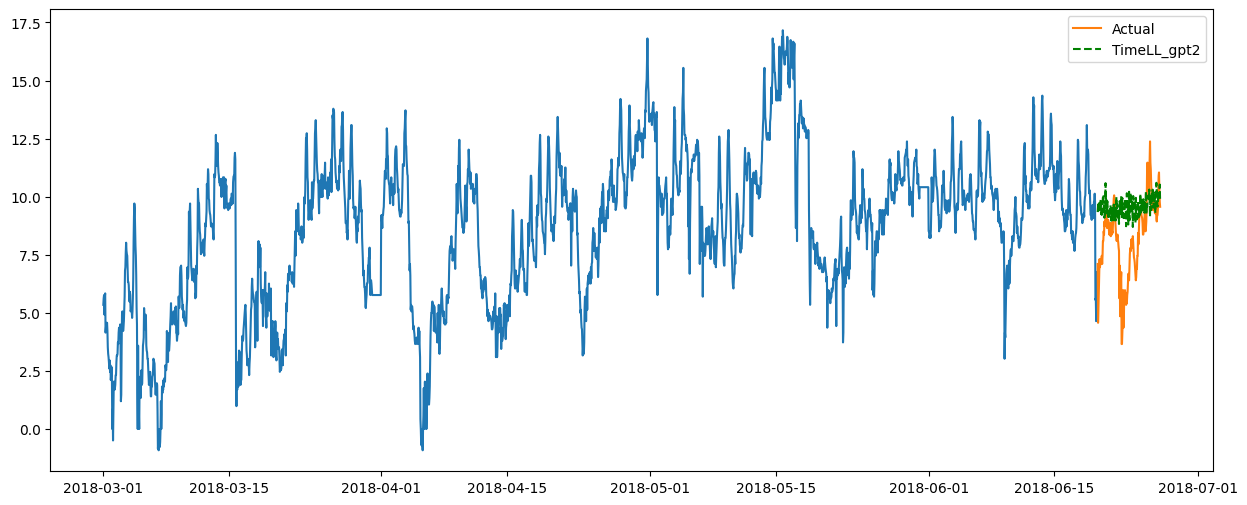

In [37]:
plt.figure(figsize=(15, 6))  # Ajuste aqui para o tamanho desejado, exemplo: 10 polegadas de largura por 6 de altura
plt.plot(Y_train_df['ds'], Y_train_df['OT'])
plt.plot(Y_test_df['ds'], Y_test_df['OT'], label='Actual')
plt.plot(Y_test_df['ds'], Y_test_df['TimeLL_gpt2'], label='TimeLL_gpt2', ls='--', color='green')
plt.legend(loc='best')
plt.show()


KeyError: 'y'

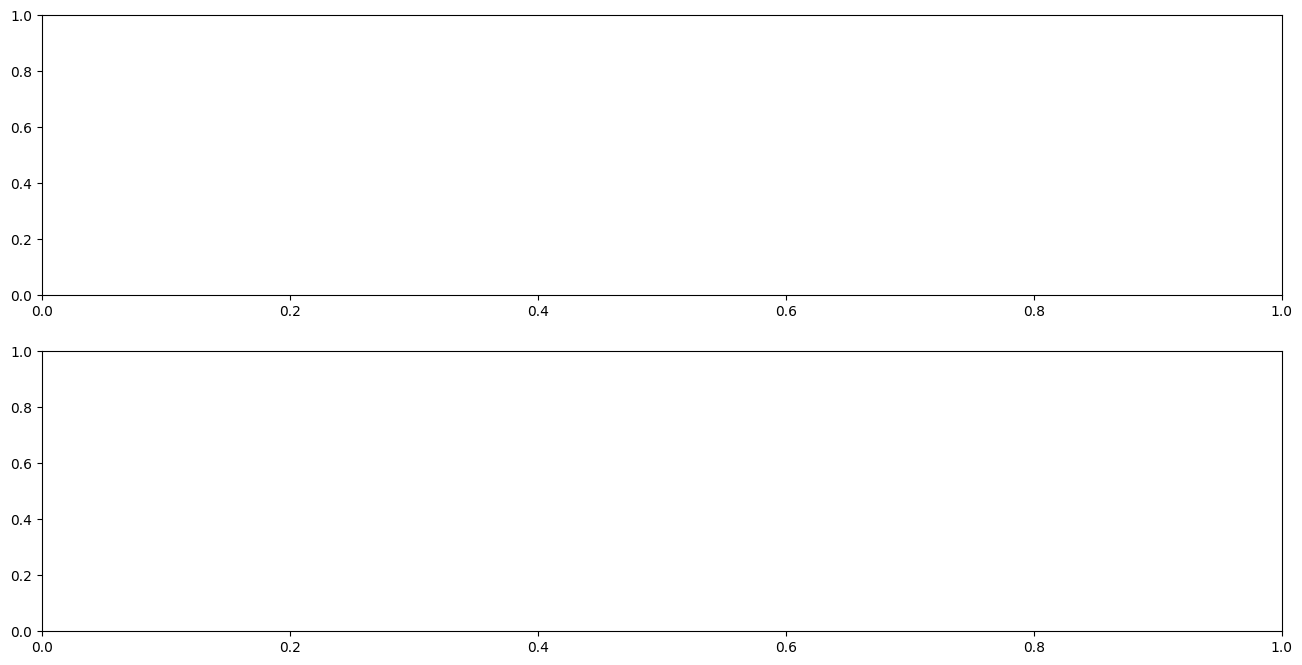

In [24]:
train1_df = Y_train_df[Y_train_df.unique_id == 'Airline1']
train2_df = Y_train_df[Y_train_df.unique_id == 'Airline2']

airline1_df = Y_test_df[Y_test_df.unique_id == 'Airline1']
airline2_df = Y_test_df[Y_test_df.unique_id == 'Airline2']

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16,8))

ax1.plot(train1_df['ds'], train1_df['y'])
ax1.plot(airline1_df['ds'], airline1_df['y'], label='Actual')
ax1.plot(airline1_df['ds'], airline1_df['TimeLL_gpt2'], label='TimeLL_gpt2', ls='--', color='green')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly passengers')

ax2.plot(train2_df['ds'], train2_df['y'])
ax2.plot(airline2_df['ds'], airline2_df['y'], label='Actual')
ax2.plot(airline2_df['ds'], airline2_df['TimeLL_gpt2'], label='TimeLL_gpt2', ls='--', color='green')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('Monthly passengers')

plt.tight_layout()

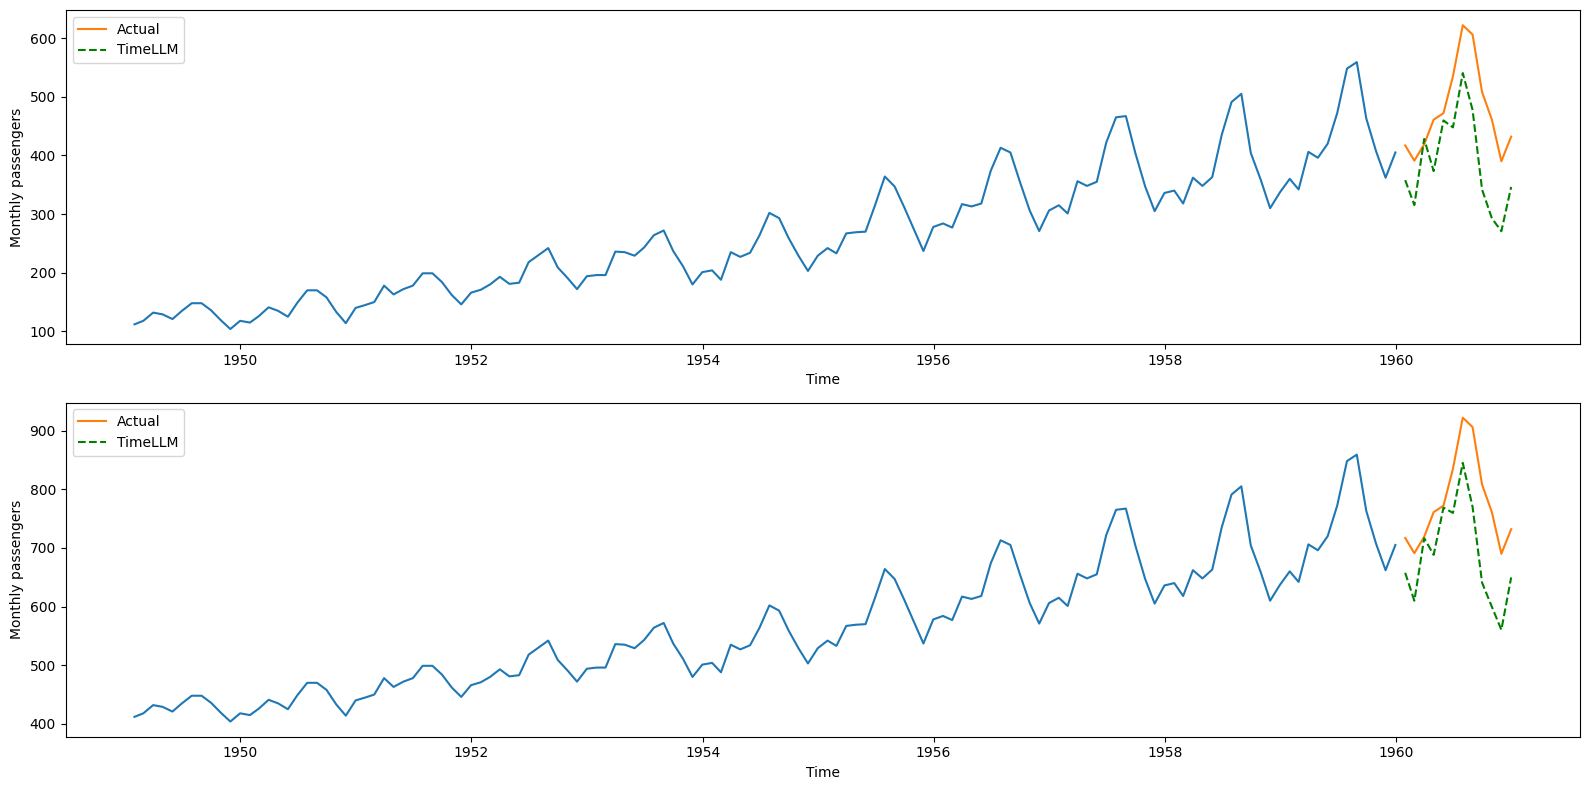

In [19]:
train1_df = Y_train_df[Y_train_df.unique_id == 'Airline1']
train2_df = Y_train_df[Y_train_df.unique_id == 'Airline2']

airline1_df = Y_test_df[Y_test_df.unique_id == 'Airline1']
airline2_df = Y_test_df[Y_test_df.unique_id == 'Airline2']

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16,8))

ax1.plot(train1_df['ds'], train1_df['y'])
ax1.plot(airline1_df['ds'], airline1_df['y'], label='Actual')
ax1.plot(airline1_df['ds'], airline1_df['TimeLLM'], label='TimeLLM', ls='--', color='green')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly passengers')

ax2.plot(train2_df['ds'], train2_df['y'])
ax2.plot(airline2_df['ds'], airline2_df['y'], label='Actual')
ax2.plot(airline2_df['ds'], airline2_df['TimeLLM'], label='TimeLLM', ls='--', color='green')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('Monthly passengers')

plt.tight_layout()

In [ ]:
train1_df = Y_train_df[Y_train_df.unique_id == 'Airline1']
train2_df = Y_train_df[Y_train_df.unique_id == 'Airline2']

airline1_df = Y_test_df[Y_test_df.unique_id == 'Airline1']
airline2_df = Y_test_df[Y_test_df.unique_id == 'Airline2']

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16,8))

ax1.plot(train1_df['ds'], train1_df['y'])
ax1.plot(airline1_df['ds'], airline1_df['y'], label='Actual')
ax1.plot(airline1_df['ds'], airline1_df['TimeLLM'], label='TimeLLM', ls='--', color='green')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly passengers')

ax2.plot(train2_df['ds'], train2_df['y'])
ax2.plot(airline2_df['ds'], airline2_df['y'], label='Actual')
ax2.plot(airline2_df['ds'], airline2_df['TimeLL_bert'], label='TimeLL_bert', ls='--', color='green')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('Monthly passengers')

plt.tight_layout()